In [13]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

### Evolutionary Strategy Idea (with elitism)
1. Population of 20 images build by triangles (start with 100) that aim to together compose mona lisa
2. In each generation we choose 5 best parents based on loss function
3. We create deep copy of each of chosen parents and with some probability mutate them in particular way
4. We repeat such process manyyyy times
Each triangle has genotype (x1, y1), (x2, y2), (x3, y3), R, G, B, a so that we can represent its vertices and color with opacity
---
Functions we need:
- main loop for algorithm
- create individual (image)
- create genotypes (particular number of triangles for image), create genotype (one triangle)
- mutation function (color, structural, general - kick triangle and create new one for bigger reset)
- loss function SSE comparing pixels
- function for turning triangles into image (concatenating to get particular pixel)

In [14]:
def render_image(genes, width, height):
    image = Image.new("RGBA", (width, height), (0, 0, 0, 255))
    draw = ImageDraw.Draw(image)
    for gene in genes:
        points = [
            (gene[0], gene[1]),
            (gene[2], gene[3]),
            (gene[4], gene[5]),
        ]
        color = tuple(map(int, gene[6:10]))

        draw.polygon(points, fill=color)

    final_image = image.convert("RGB")
    
    return np.array(final_image)

In [15]:
# loss function - difference between particular pixels in images
def calculate_fitness_score(image1, image2):
    loss = np.sum(np.square(image1.astype(np.int64) - image2.astype(np.int64)))
    return loss

In [16]:
def create_gene(im_height, im_width):
    gene = []
    x_l = np.random.randint(-50, im_width + 50, size=3)
    y_l = np.random.randint(-50, im_height + 50, size=3)

    for x, y in zip(x_l, y_l):
        gene.append(x)
        gene.append(y)

    r = np.random.randint(0, 256)
    g = np.random.randint(0, 256)
    b = np.random.randint(0, 256)
    a = np.random.randint(0, 256)

    gene += [r, g, b, a]

    return np.array(gene)

In [17]:
def create_individual(t, im_height, im_width):
    genes = [create_gene(im_height, im_width) for _ in range(t)]

    return np.array(genes)

In [18]:
def create_population(n, t, im_height, im_width):
    population = []
    for _ in range(n):
        ind = create_individual(t, im_height, im_width)
        population.append(ind)
    
    return population

In [19]:
def mutate(ind, t, im_height, im_width):
    idx = np.random.randint(0, t)
    gene = ind[idx]

    if np.random.rand() < 0.5:
        coord_idx = np.random.randint(0, 6)
        change = np.random.randint(-20, 21)
        gene[coord_idx] += change

        if coord_idx % 2 == 0:
            gene[coord_idx] = np.clip(gene[coord_idx], -50, im_width + 50)
        else:
            gene[coord_idx] = np.clip(gene[coord_idx], -50, im_height + 50)
    else:
        color_idx = np.random.randint(6, 10)
        change = np.random.randint(-30, 31)
        gene[color_idx] += change

        gene[color_idx] = np.clip(gene[color_idx], 0, 255)

### Main algorithm

In [20]:
"""
(Mu + Lambda) = (5 + 15)
n - population size
m - elitism (how many parents go to next population)
t - number of triangles in one image
generations

genotype - x1, y1, x2, y2, x3, y3, r, g, b, a
"""
def es_elitism(n, m, t, generations, original_image):
    height = original_image.shape[0]
    width = original_image.shape[1]
    per_parent_children = (n - m) // m
    
    population = create_population(n, t, height, width)
    fitness_scores = np.zeros(n)
    # generate image from numpy array (without opacity)
    for i in range(n):
        curr_im = render_image(population[i], width, height)
        fitness_scores[i] = calculate_fitness_score(original_image, curr_im)

    # visualize
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    ax_flat = axes.flatten()

    ax_flat[0].imshow(original_image)
    ax_flat[0].set_title("Original")
    ax_flat[0].axis("off")

    plt.close()

    for generation in range(generations):
        # sort population based on their fitness (get their indices)
        sorted_indices = np.argsort(fitness_scores)
        top_5_indices = sorted_indices[:5]
        worst_indices = sorted_indices[5:]

        # visualize progress
        if generation % 50 == 0:
            best_fitness = fitness_scores[top_5_indices[0]]
            # print(f"Generation = {generation}. Best loss function {best_fitness}")

            for k in range(5):
                idx = top_5_indices[k]
                img = render_image(population[idx], width, height)
                ax_plot = ax_flat[k + 1]
                ax_plot.clear()
                ax_plot.imshow(img)
                ax_plot.set_title(f"Top {k + 1} generation {generation}")
                ax_plot.axis("off")
            
            clear_output(wait=True)
            display(fig)

        # iterate through each child and mutate it
        child_num = 0
        for parent_idx in top_5_indices:
            for _ in range(per_parent_children):
                target_place = worst_indices[child_num]
                population[target_place] = population[parent_idx].copy()
                mutate(population[target_place], t, height, width)

                curr_im = render_image(population[target_place], width, height)
                fitness_scores[target_place] = calculate_fitness_score(
                    original_image, curr_im)
                child_num += 1
    
    return sorted_indices[0]

### Read data

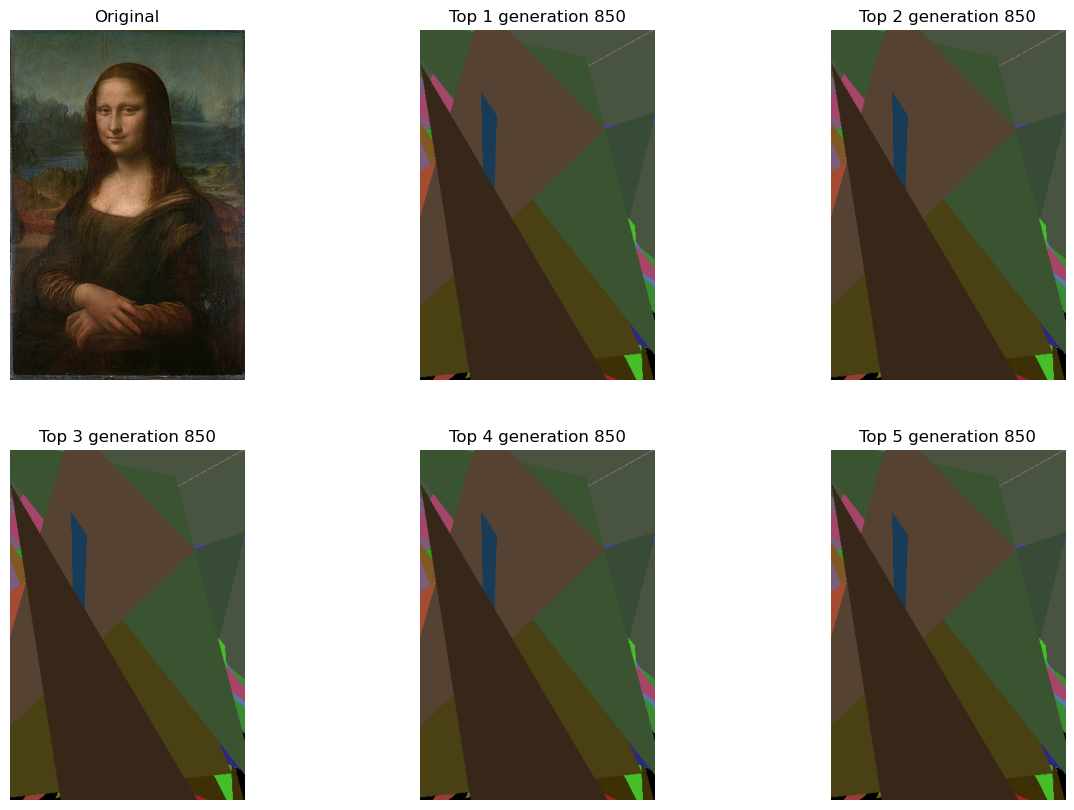

KeyboardInterrupt: 

In [21]:
image_path = "MonaLisaS.jpg"
mona_lisa = Image.open(image_path).convert("RGB")
mona_lisa_array = np.array(mona_lisa)

N = 20
M = 5
T = 100
GENERATIONS = 10000

best_genes = es_elitism(N, M, T, GENERATIONS, mona_lisa_array)